In [6]:
import sys

import sklearn
from sklearn.datasets import load_digits

sys.path.append('..')
import torch
import numpy as np
import matplotlib.pyplot as plt

from deep_logic.utils.relunn import get_reduced_model, prune_features
from deep_logic import fol
import deep_logic as dl

torch.manual_seed(0)
np.random.seed(0)



In [8]:
# %%

X, y = load_digits(return_X_y=True)
y = sklearn.preprocessing.OneHotEncoder(sparse=False).fit_transform(y.reshape(-1, 1))
X -= X.min()
X /= X.max()
print(f'X shape: {X.shape}\nClasses: {np.unique(y)}')
print(f'X max: {X.max()}')

X shape: (1797, 64)
Classes: [0. 1.]
X max: 1.0


In [9]:
from sklearn.model_selection import train_test_split
X, X_test, y, y_test = train_test_split(X, y, test_size=0.1)
print(f'X shape: {X.shape}\nY shape: {y.shape}')
print(f'X_test shape: {X_test.shape}\nY_test shape: {y_test.shape}')

X shape: (1617, 64)
Y shape: (1617, 10)
X_test shape: (180, 64)
Y_test shape: (180, 10)


In [10]:
concept_names = [f"f_{i}" for i in range(X.shape[1])]
concept_names

['f_0',
 'f_1',
 'f_2',
 'f_3',
 'f_4',
 'f_5',
 'f_6',
 'f_7',
 'f_8',
 'f_9',
 'f_10',
 'f_11',
 'f_12',
 'f_13',
 'f_14',
 'f_15',
 'f_16',
 'f_17',
 'f_18',
 'f_19',
 'f_20',
 'f_21',
 'f_22',
 'f_23',
 'f_24',
 'f_25',
 'f_26',
 'f_27',
 'f_28',
 'f_29',
 'f_30',
 'f_31',
 'f_32',
 'f_33',
 'f_34',
 'f_35',
 'f_36',
 'f_37',
 'f_38',
 'f_39',
 'f_40',
 'f_41',
 'f_42',
 'f_43',
 'f_44',
 'f_45',
 'f_46',
 'f_47',
 'f_48',
 'f_49',
 'f_50',
 'f_51',
 'f_52',
 'f_53',
 'f_54',
 'f_55',
 'f_56',
 'f_57',
 'f_58',
 'f_59',
 'f_60',
 'f_61',
 'f_62',
 'f_63']

In [11]:
# %%
print(y)
x_train = torch.tensor(X, dtype=torch.float)
print(x_train.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
torch.Size([1617, 64])


In [12]:
# %%

y_train = torch.zeros((y.shape[0], y.shape[1]), dtype=torch.float)
y_train = torch.tensor(y, dtype=torch.float)
x_test = x_train
n_classes = y_train.size(1)
print(n_classes)
y_train

10


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

In [13]:
# %%

y_train.sum(dim=0)

tensor([167., 162., 161., 173., 171., 161., 156., 159., 151., 156.])

In [14]:
# %%

torch.manual_seed(0)
np.random.seed(0)

layers = [
    torch.nn.Linear(x_train.size(1), 50 * n_classes),
    torch.nn.LeakyReLU(),
    dl.nn.XLinear(50, 20, n_classes),
    torch.nn.LeakyReLU(),
    dl.nn.XLinear(20, 10, n_classes),
    torch.nn.LeakyReLU(),
    dl.nn.XLinear(10, 1, n_classes),
    torch.nn.Softmax(),
]
model = torch.nn.Sequential(*layers)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_form = torch.nn.BCELoss()
model.train()
need_pruning = True
for epoch in range(3000):
    # forward pass
    optimizer.zero_grad()
    y_pred = model(x_train)
    # Compute Loss
    loss = loss_form(y_pred, y_train)

    for module in model.children():
        if isinstance(module, torch.nn.Linear):
            loss += 0.0001 * torch.norm(module.weight, 1)
            break

    # backward pass
    loss.backward()
    optimizer.step()

    if epoch > 1500 and need_pruning:
        prune_features(model, n_classes)
        need_pruning = False

    # compute accuracy
    if (epoch + 1) % 100 == 0:
        y_pred_d = torch.argmax(y_pred, dim=1)
        y_train_d = torch.argmax(y_train, dim=1)
        accuracy = y_pred_d.eq(y_train_d).sum().item() / y_train.size(0)
        print(f'Epoch {epoch + 1}: train accuracy: {accuracy:.4f}')

C:\Users\gabri\Anaconda3\envs\fsc\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch 100: train accuracy: 0.9351
Epoch 200: train accuracy: 0.9889
Epoch 300: train accuracy: 0.9969
Epoch 400: train accuracy: 0.9981
Epoch 500: train accuracy: 0.9994
Epoch 600: train accuracy: 0.9994
Epoch 700: train accuracy: 1.0000
Epoch 800: train accuracy: 1.0000
Epoch 900: train accuracy: 1.0000
Epoch 1000: train accuracy: 0.9963
Epoch 1100: train accuracy: 0.9988
Epoch 1200: train accuracy: 0.9988
Epoch 1300: train accuracy: 1.0000
Epoch 1400: train accuracy: 1.0000
Epoch 1500: train accuracy: 1.0000
Epoch 1600: train accuracy: 0.9388
Epoch 1700: train accuracy: 0.9481
Epoch 1800: train accuracy: 0.9511
Epoch 1900: train accuracy: 0.9549
Epoch 2000: train accuracy: 0.9579
Epoch 2100: train accuracy: 0.9592
Epoch 2200: train accuracy: 0.9579
Epoch 2300: train accuracy: 0.9586
Epoch 2400: train accuracy: 0.9604
Epoch 2500: train accuracy: 0.9623
Epoch 2600: train accuracy: 0.9641
Epoch 2700: train accuracy: 0.9666
Epoch 2800: train accuracy: 0.9678
Epoch 2900: train accuracy: 0

Input 1
	x=[0.   0.   0.   0.56 0.69 0.   0.   0.   0.   0.   0.12 0.94 0.5  0.
 0.   0.   0.   0.   0.69 0.94 0.06 0.19 0.5  0.   0.   0.38 1.   0.25
 0.   0.88 0.75 0.   0.   0.75 1.   0.25 0.69 1.   0.31 0.   0.   0.56
 1.   1.   1.   0.69 0.   0.   0.   0.   0.38 0.69 1.   0.44 0.   0.
 0.   0.   0.   0.62 1.   0.25 0.   0.  ]
	y=[0.   0.91 0.   0.   1.   0.02 0.99 0.96 0.   0.  ], y_label=tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
	w=[[  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.   -29.57   0.
    0.     0.     0.     0.     0.     0.   -26.16   0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     2.6  

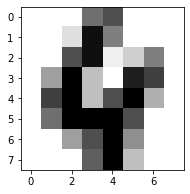

Input 3
	x=[0.   0.   0.   0.62 0.81 0.06 0.   0.   0.   0.06 0.69 0.75 0.44 0.
 0.   0.   0.   0.12 1.   0.75 0.   0.   0.   0.   0.   0.25 1.   0.69
 0.   0.   0.   0.   0.   0.25 1.   0.94 0.5  0.25 0.   0.   0.   0.25
 1.   1.   0.81 1.   0.38 0.   0.   0.   0.44 1.   0.44 0.81 0.88 0.
 0.   0.   0.   0.44 0.94 0.94 0.31 0.  ]
	y=[0.07 0.   0.01 0.   0.   0.5  1.   0.   0.   0.  ], y_label=tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])
	w=[[  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.   -29.57   0.
    0.     0.     0.     0.     0.     0.   -26.16   0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     2.4  

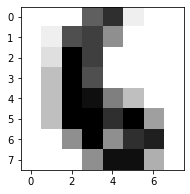

Input 4
	x=[0.   0.   0.31 0.94 1.   0.94 0.06 0.   0.   0.62 1.   0.69 0.5  1.
 0.31 0.   0.   0.75 0.62 0.06 0.62 0.94 0.06 0.   0.   0.   0.   0.5
 1.   0.69 0.06 0.   0.   0.   0.   0.06 0.62 1.   0.62 0.   0.   0.
 0.   0.12 0.   0.44 1.   0.   0.   0.   0.5  0.81 0.31 0.94 0.75 0.
 0.   0.   0.31 0.94 1.   0.88 0.19 0.  ]
	y=[0.   0.   0.97 1.   0.   0.01 0.   0.   0.06 1.  ], y_label=tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
	w=[[  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.    -5.27   0.
    0.     0.     0.     0.     0.     0.    -4.66   0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     7.2    0

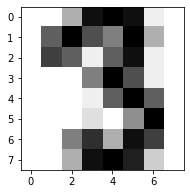

Input 5
	x=[0.   0.   0.56 0.81 1.   0.31 0.   0.   0.   0.19 1.   0.5  0.25 0.81
 0.   0.   0.   0.38 0.62 0.06 0.   0.56 0.12 0.   0.   0.31 0.25 0.
 0.   0.25 0.5  0.   0.   0.5  0.25 0.   0.   0.25 0.5  0.   0.   0.38
 0.38 0.   0.   0.25 0.56 0.   0.   0.   0.81 0.12 0.   0.44 0.5  0.
 0.   0.   0.5  0.75 0.81 0.94 0.12 0.  ]
	y=[1.   0.   0.06 1.   0.06 0.89 0.   0.   0.   0.02], y_label=tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
	w=[[  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.   -29.57   0.
    0.     0.     0.     0.     0.     0.   -26.16   0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     6.41 

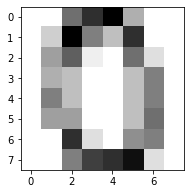

Input 6
	x=[0.   0.   0.06 0.56 1.   0.38 0.   0.   0.   0.25 0.88 0.62 0.69 0.62
 0.   0.   0.   0.75 0.62 0.   0.81 0.38 0.   0.   0.   0.38 0.44 0.25
 1.   0.31 0.   0.   0.   0.   0.   0.   0.44 0.75 0.06 0.   0.   0.
 0.   0.   0.   0.5  0.62 0.   0.   0.   0.5  0.81 0.19 0.   0.88 0.19
 0.   0.   0.   0.5  1.   1.   0.81 0.19]
	y=[0.   0.   0.01 0.99 0.   0.   0.   0.   0.   0.2 ], y_label=tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
	w=[[  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.    -5.27   0.
    0.     0.     0.     0.     0.     0.    -4.66   0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.    12.7

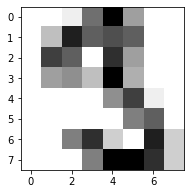

Input 7
	x=[0.   0.   0.44 0.88 0.94 0.44 0.   0.   0.   0.38 1.   0.5  0.44 1.
 0.25 0.   0.   0.69 0.38 0.06 0.62 0.88 0.06 0.   0.   0.06 0.   0.25
 1.   0.38 0.   0.   0.   0.   0.   0.12 0.69 0.81 0.06 0.   0.   0.
 0.   0.   0.   0.69 0.44 0.   0.   0.   0.19 0.25 0.5  0.88 0.19 0.
 0.   0.   0.62 0.81 0.75 0.25 0.   0.  ]
	y=[0.   0.   0.01 1.   0.   0.01 0.   0.   0.   0.99], y_label=tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
	w=[[  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.    -5.27   0.
    0.     0.     0.     0.     0.     0.    -4.66   0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     8.98   

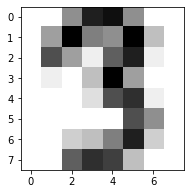

Input 8
	x=[0.   0.06 0.62 0.88 0.81 0.25 0.   0.   0.   0.75 0.69 0.31 0.5  0.88
 0.   0.   0.   0.5  0.19 0.12 0.75 0.5  0.   0.   0.   0.   0.19 0.94
 0.94 0.25 0.   0.   0.   0.   0.06 0.25 0.44 0.88 0.31 0.   0.   0.
 0.   0.   0.   0.44 0.75 0.   0.   0.   0.   0.   0.06 0.69 0.69 0.
 0.   0.   0.75 1.   1.   0.56 0.06 0.  ]
	y=[0.   0.   0.97 1.   0.   0.03 0.   0.   0.01 0.99], y_label=tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
	w=[[  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.    -5.27   0.
    0.     0.     0.     0.     0.     0.    -4.66   0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     4.78 

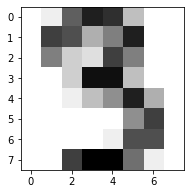

Input 9
	x=[0.   0.   0.44 0.88 0.5  0.25 0.   0.   0.   0.   1.   0.5  0.94 0.88
 0.06 0.   0.   0.25 1.   0.25 0.   0.5  0.25 0.   0.   0.5  0.88 0.
 0.   0.25 0.25 0.   0.   0.5  1.   0.   0.   0.25 0.31 0.   0.   0.19
 1.   0.06 0.   0.69 0.25 0.   0.   0.   0.94 1.   1.   0.75 0.   0.
 0.   0.   0.38 0.81 0.44 0.   0.   0.  ]
	y=[1.   0.   0.   0.   0.32 0.42 0.43 0.49 0.19 0.01], y_label=tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
	w=[[  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.   -29.57   0.
    0.     0.     0.     0.     0.     0.   -26.16   0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     7.16 

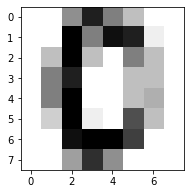

Input 10
	x=[0.   0.   0.   0.25 0.81 1.   0.94 0.12 0.   0.   0.12 0.94 0.81 0.81
 1.   0.38 0.   0.   0.44 0.44 0.   0.19 1.   0.25 0.   0.   0.   0.25
 0.25 0.5  0.88 0.   0.   0.   0.88 1.   1.   1.   0.38 0.   0.   0.
 0.69 0.56 0.62 0.75 0.   0.   0.   0.   0.   0.   0.81 0.19 0.   0.
 0.   0.   0.   0.25 0.62 0.   0.   0.  ]
	y=[0.   0.02 0.63 0.   0.52 0.13 0.26 1.   0.   0.  ], y_label=tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])
	w=[[  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.    -5.27   0.
    0.     0.     0.     0.     0.     0.    -4.66   0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     2.61

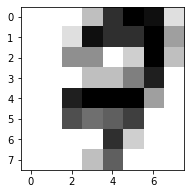

Input 11
	x=[0.   0.   0.06 0.56 1.   1.   1.   0.06 0.   0.   0.5  0.94 0.62 0.88
 0.81 0.   0.   0.   0.88 0.38 0.   0.88 0.38 0.   0.   0.   0.38 0.12
 0.38 1.   0.19 0.   0.   0.   0.   0.75 1.   1.   0.62 0.   0.   0.
 0.   0.38 1.   0.5  0.   0.   0.   0.   0.   0.44 0.81 0.   0.   0.
 0.   0.   0.   0.88 0.38 0.   0.   0.  ]
	y=[0.   0.   0.   0.   0.   0.02 0.   0.97 0.14 0.01], y_label=tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])
	w=[[  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.    -5.27   0.
    0.     0.     0.     0.     0.     0.    -4.66   0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.    -1.28

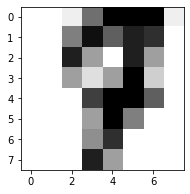

Input 12
	x=[0.   0.   0.56 0.5  0.75 0.81 0.06 0.   0.   0.19 0.94 0.5  0.31 0.25
 0.   0.   0.   0.38 0.56 0.12 0.38 0.12 0.   0.   0.   0.38 1.   0.88
 0.56 0.81 0.25 0.   0.   0.12 0.44 0.   0.   0.44 0.5  0.   0.   0.
 0.   0.   0.   0.44 0.62 0.   0.   0.   0.5  0.31 0.38 0.88 0.19 0.
 0.   0.   0.62 0.88 0.94 0.31 0.   0.  ]
	y=[0.   0.   0.   0.   0.43 1.   0.   0.   0.06 0.08], y_label=tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])
	w=[[  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.   -29.57   0.
    0.     0.     0.     0.     0.     0.   -26.16   0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     0.  ]
 [  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    0.     0.     0.     4.13

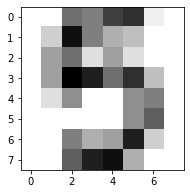

In [15]:
# %% md

# Local explanations

# %%

np.set_printoptions(precision=2, suppress=True)
outputs = []
for i, (xin, yin) in enumerate(zip(x_train, y_train)):
    model_reduced = get_reduced_model(model, xin)
    for module in model_reduced.children():
        if isinstance(module, torch.nn.Linear):
            wa = module.weight.detach().numpy()
            ba = module.bias.detach().numpy()
            break
    output = model_reduced(xin)

    pred_class = torch.argmax(output)
    true_class = torch.argmax(y_train[i])

    # generate local explanation only if the prediction is correct
    if pred_class.eq(true_class):
        local_explanation = fol.relunn.explain_local(model, x_train, y_train, xin)
        print(f'Input {(i + 1)}')
        print(f'\tx={xin.detach().numpy()}')
        print(f'\ty={output.detach().numpy()}, y_label={yin}')
        print(f'\tw={wa}')
        print(f'\tb={ba}')
        print(f'\tExplanation: {local_explanation}')
        print()
        xin = xin.reshape(8, 8)
        plt.figure(1, figsize=(3, 3))
        plt.imshow(xin, cmap=plt.cm.gray_r, interpolation='nearest')
        plt.show()
#         wa = wa.reshape(8, 8)
#         plt.figure(1, figsize=(3, 3))
#         plt.imshow(wa * xin.numpy(), cmap=plt.cm.gray_r, interpolation='nearest')
#         plt.show()

    outputs.append(output)
    if i > 10:
        break

In [17]:
# %% md

# Combine local explanations

# %%
counters = []
from sklearn.metrics import f1_score
y_train_d = torch.argmax(y_train, dim=1)
for target_class in range(n_classes):
    global_explanation, predictions, counter = fol.combine_local_explanations(model, x_train, y_train,
                                                                              topk_explanations=10,
                                                                              target_class=target_class,
                                                                              concept_names=concept_names)

    y2 = torch.argmax(y_train, dim=1) == target_class
    accuracy = sum(predictions == y2.detach().numpy().squeeze()) / len(predictions)
    f1 = f1_score(y_train[:, target_class], predictions)
    print(f'Class {target_class} - Global explanation: "{global_explanation}" - Accuracy: {accuracy:.4f} - F1: {f1:.4f}')
    counters.append(counter)


Class 0 - Global explanation: "~f_28 & ~f_36" - Accuracy: 0.9177 - F1: 0.7152
Class 1 - Global explanation: "(f_19 & f_27 & f_35 & ~f_46 & ~f_63) | (f_19 & f_27 & f_59 & ~f_13 & ~f_46) | (f_13 & f_27 & f_35 & ~f_46 & ~f_59 & ~f_63) | (f_13 & f_19 & ~f_35 & ~f_46 & ~f_59 & ~f_63)" - Accuracy: 0.8621 - F1: 0.5863


KeyboardInterrupt: 

In [18]:
for i, counter in enumerate(counters):
    for j, values in enumerate(counter.items()):
        print(i, j, values)

0 0 ('~f_28 & ~f_36', 165)
1 0 ('~f_13 & f_19 & f_27 & f_35 & ~f_46 & f_59 & ~f_63', 58)
1 1 ('f_13 & f_19 & ~f_27 & ~f_35 & ~f_46 & ~f_59 & ~f_63', 11)
1 2 ('f_13 & f_19 & f_27 & ~f_35 & ~f_46 & ~f_59 & ~f_63', 21)
1 3 ('f_13 & f_19 & f_27 & f_35 & ~f_46 & ~f_59 & ~f_63', 16)
1 4 ('~f_13 & f_19 & f_27 & f_35 & ~f_46 & f_59 & f_63', 10)
1 5 ('~f_13 & f_19 & f_27 & ~f_35 & ~f_46 & f_59 & ~f_63', 2)
1 6 ('~f_13 & f_19 & f_27 & ~f_35 & ~f_46 & f_59 & f_63', 5)
1 7 ('f_13 & ~f_19 & f_27 & f_35 & ~f_46 & ~f_59 & ~f_63', 2)
1 8 ('f_13 & f_19 & f_27 & f_35 & ~f_46 & f_59 & ~f_63', 25)
1 9 ('~f_13 & f_19 & f_27 & f_35 & ~f_46 & ~f_59 & ~f_63', 6)
1 10 ('f_13 & f_19 & ~f_27 & f_35 & ~f_46 & f_59 & ~f_63', 1)
1 11 ('~f_13 & f_19 & ~f_27 & f_35 & ~f_46 & f_59 & ~f_63', 1)
1 12 ('f_13 & ~f_19 & f_27 & ~f_35 & ~f_46 & ~f_59 & ~f_63', 1)
1 13 ('~f_13 & f_19 & f_27 & ~f_35 & ~f_46 & ~f_59 & ~f_63', 1)


In [27]:
from sklearn.metrics import f1_score, accuracy_score
y_pred = model(torch.Tensor(X_test)).argmax(dim=1).detach().numpy()
y_test = np.argmax(y_test, axis=1)


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [42]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
print(f"Accuracy: {accuracy:.2f}.\nF1: {f1}")

Accuracy: 0.84.
F1: 0.8367041408858945


In [45]:
from sklearn.tree import DecisionTreeClassifier
tree_model = DecisionTreeClassifier()
X_bool = X > 0.5
tree_model.fit(X, y_train_d)
X_test_bool = X_test > 0.5
y_pred = tree_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
print(f"Accuracy: {accuracy:.2f}.\nF1: {f1:.2f}")

Accuracy: 0.85.
F1: 0.85


[Text(93.55618261455527, 209.07692307692307, 'X[36] <= 0.031\ngini = 0.9\nsamples = 1617\nvalue = [167, 162, 161, 173, 171, 161, 156, 159, 151, 156]'),
 Text(22.560646900269543, 192.35076923076923, 'X[28] <= 0.281\ngini = 0.535\nsamples = 252\nvalue = [163, 0, 3, 1, 6, 22, 5, 0, 3, 49]'),
 Text(12.633962264150945, 175.62461538461537, 'X[21] <= 0.031\ngini = 0.187\nsamples = 181\nvalue = [163, 0, 2, 0, 6, 5, 3, 0, 0, 2]'),
 Text(9.024258760107816, 158.89846153846153, 'X[5] <= 0.656\ngini = 0.75\nsamples = 16\nvalue = [1, 0, 2, 0, 5, 5, 3, 0, 0, 0]'),
 Text(7.219407008086254, 142.1723076923077, 'X[37] <= 0.344\ngini = 0.678\nsamples = 11\nvalue = [1, 0, 2, 0, 5, 0, 3, 0, 0, 0]'),
 Text(5.41455525606469, 125.44615384615385, 'X[51] <= 0.969\ngini = 0.611\nsamples = 6\nvalue = [1, 0, 2, 0, 0, 0, 3, 0, 0, 0]'),
 Text(3.609703504043127, 108.72, 'X[45] <= 0.312\ngini = 0.444\nsamples = 3\nvalue = [1, 0, 2, 0, 0, 0, 0, 0, 0, 0]'),
 Text(1.8048517520215634, 91.99384615384615, 'gini = 0.0\nsample

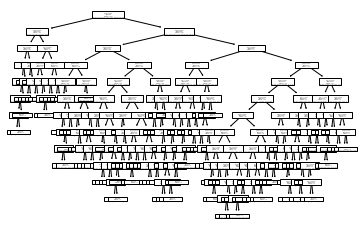

In [46]:
sklearn.tree.plot_tree(tree_model)
# plt.show()